In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping

In [2]:
data_dir = r"C:\Users\91849\Desktop\final_year_project\TK14876\DATASET\Alzheimer_s Dataset\train"

In [3]:
classifiers=[]
for file in os.listdir(data_dir):
    classifiers+=[file]
print(classifiers)
print(len(classifiers))

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
4


In [4]:
train_dir = os.path.join(data_dir)

train_data = []
for defects_id, sp in enumerate(classifiers):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'LabelID', 'Label'])
train.head()

,File,LabelID,Label
0,MildDemented/mildDem0.jpg,0,MildDemented
1,MildDemented/mildDem1.jpg,0,MildDemented
2,MildDemented/mildDem10.jpg,0,MildDemented
3,MildDemented/mildDem100.jpg,0,MildDemented
4,MildDemented/mildDem101.jpg,0,MildDemented


In [5]:
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))  # Reset indices
train.tail()

,File,LabelID,Label
8056,NonDemented/nonDem2363.jpg,2,NonDemented
8057,NonDemented/nonDem2510.jpg,2,NonDemented
8058,MildDemented/nonhealthy_0_2142.jpg,0,MildDemented
8059,VeryMildDemented/verymildDem587.jpg,3,VeryMildDemented
8060,VeryMildDemented/verymildDem287.jpg,3,VeryMildDemented


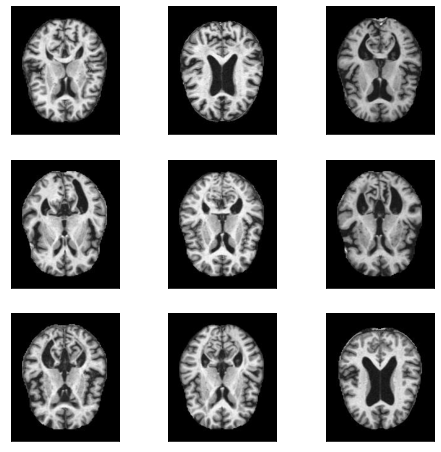

In [6]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8))
    defect_files = train['File'][train['Label'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
plot_defects('VeryMildDemented', 3, 3)

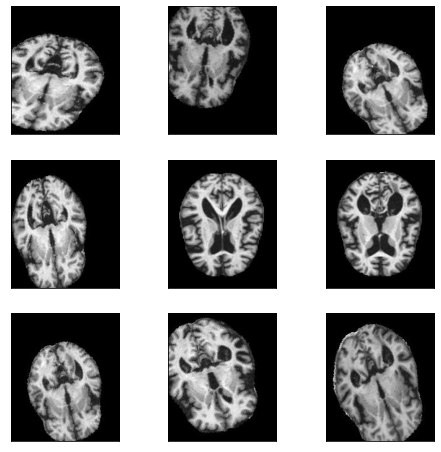

In [7]:
plot_defects('MildDemented', 3, 3)

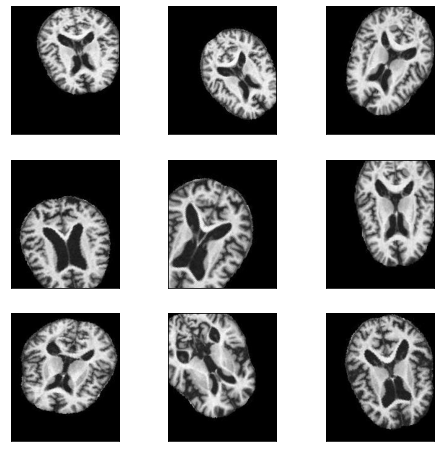

In [8]:
plot_defects('ModerateDemented', 3, 3)

In [9]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2)


train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    class_mode='categorical')

Found 8061 images belonging to 4 classes.


In [10]:
IMAGE_SIZE = 128


def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))


def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
x_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        x_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))


x_train = x_train / 255.

num_classes=4
y_train = train['LabelID'].values
y_train = to_categorical(y_train,num_classes)

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=SEED)
print('Train Shape: {}'.format(X_train.shape))
print('Train Shape: {}'.format(Y_train.shape))

8061it [00:29, 271.56it/s]


In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(classifiers[np.argmax(Y_train[i])])

In [13]:
from tensorflow.keras.regularizers import l2

In [14]:
model = Sequential()
model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3, strides = 2,input_shape=(128,128,3)))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Flatten())
model.add(Dense(128,activation="relu"))


model.add(Dense(num_classes,kernel_regularizer=l2(0.01),activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, mode='min')

In [16]:
model.compile(optimizer="adam",loss="squared_hinge", metrics = ['accuracy'])
hist = model.fit(X_train,Y_train,epochs=100,batch_size=10,validation_data=(X_test,Y_test),callbacks=[early_stopping])

Epoch 1/100
565/565 [==============================] - 38s 55ms/step - loss: 1.1431 - accuracy: 0.5922 - val_loss: 1.0701 - val_accuracy: 0.6767
Epoch 2/100
565/565 [==============================] - 21s 38ms/step - loss: 1.0489 - accuracy: 0.6905 - val_loss: 1.0280 - val_accuracy: 0.7197
Epoch 3/100
565/565 [==============================] - 21s 37ms/step - loss: 0.9933 - accuracy: 0.7547 - val_loss: 0.9864 - val_accuracy: 0.7702
Epoch 4/100
565/565 [==============================] - 21s 37ms/step - loss: 0.9506 - accuracy: 0.8056 - val_loss: 0.9728 - val_accuracy: 0.7747
Epoch 5/100
565/565 [==============================] - 21s 37ms/step - loss: 0.9098 - accuracy: 0.8476 - val_loss: 0.9392 - val_accuracy: 0.8152
Epoch 6/100
565/565 [==============================] - 22s 38ms/step - loss: 0.8725 - accuracy: 0.8896 - val_loss: 0.9803 - val_accuracy: 0.7652
Epoch 7/100
565/565 [==============================] - 21s 37ms/step - loss: 0.8507 - accuracy: 0.9110 - val_loss: 0.9090 - val_ac

In [17]:
model.evaluate(X_test, Y_test)
model.save("SVC.h5")

76/76 [==============================] - 2s 24ms/step - loss: 0.8609 - accuracy: 0.8905


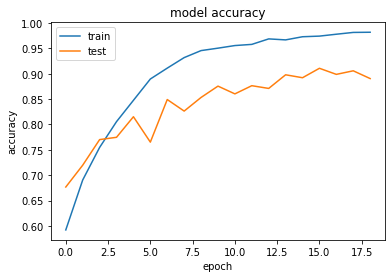

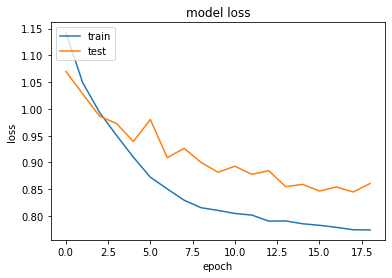

In [18]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
from tensorflow import keras

In [23]:
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [128, 128,3]),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6291584   
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 6,302,052
Trainable params: 6,302,052
Non-trainable params: 0
_________________________________________________________________


In [24]:
model1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
hist1=model1.fit(X_train,Y_train,epochs=100,batch_size=10,validation_data=(X_test,Y_test),callbacks=[early_stopping])

Epoch 1/100
565/565 [==============================] - 51s 82ms/step - loss: 1.1185 - accuracy: 0.4977 - val_loss: 0.8333 - val_accuracy: 0.5411
Epoch 2/100
565/565 [==============================] - 21s 37ms/step - loss: 0.8964 - accuracy: 0.5440 - val_loss: 0.8957 - val_accuracy: 0.5081
Epoch 3/100
565/565 [==============================] - 21s 37ms/step - loss: 0.8516 - accuracy: 0.5509 - val_loss: 0.7774 - val_accuracy: 0.5821
Epoch 4/100
565/565 [==============================] - 21s 38ms/step - loss: 0.8067 - accuracy: 0.5762 - val_loss: 0.7657 - val_accuracy: 0.5874
Epoch 5/100
565/565 [==============================] - 21s 37ms/step - loss: 0.7752 - accuracy: 0.5943 - val_loss: 0.7459 - val_accuracy: 0.6011
Epoch 6/100
565/565 [==============================] - 21s 37ms/step - loss: 0.7268 - accuracy: 0.6219 - val_loss: 0.8172 - val_accuracy: 0.5796
Epoch 7/100
565/565 [==============================] - 21s 37ms/step - loss: 0.7238 - accuracy: 0.6317 - val_loss: 0.6701 - val_ac

In [25]:
model1.evaluate(X_test, Y_test)
model1.save("ANN.h5")

76/76 [==============================] - 1s 10ms/step - loss: 1.2821 - accuracy: 0.6077


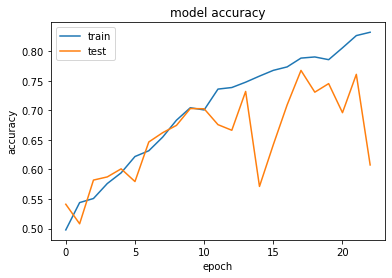

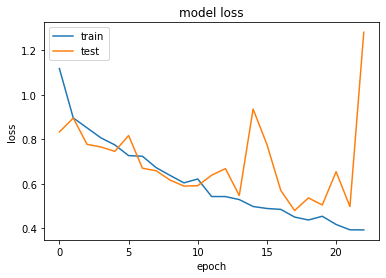

In [26]:
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
model2 = Sequential()

model2.add(Conv2D(128, kernel_size=(3,3),activation='relu',input_shape=(128,128,3)))
model2.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
model2.add(Conv2D(32, kernel_size=(3,3),activation='relu'))
model2.add(Flatten())
model2.add(Dense(num_classes,kernel_regularizer=l2(0.01), activation='softmax'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 128)     3584      
                                                                 
 conv2d_6 (Conv2D)           (None, 124, 124, 64)      73792     
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 122, 32)      18464     
                                                                 
 flatten_3 (Flatten)         (None, 476288)            0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1905156   
                                                                 
Total params: 2,000,996
Trainable params: 2,000,996
Non-trainable params: 0
_________________________________________________________________


In [36]:
model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

In [37]:
hist2 = model2.fit(X_train,Y_train,epochs=100,batch_size=10,validation_data=(X_test,Y_test),callbacks=[early_stopping])

Epoch 1/100
565/565 [==============================] - 682s 1s/step - loss: 1.0774 - accuracy: 0.5796 - val_loss: 0.9135 - val_accuracy: 0.6833
Epoch 2/100
565/565 [==============================] - 691s 1s/step - loss: 0.8982 - accuracy: 0.7120 - val_loss: 0.8819 - val_accuracy: 0.7272
Epoch 3/100
565/565 [==============================] - 688s 1s/step - loss: 0.7817 - accuracy: 0.8139 - val_loss: 0.9380 - val_accuracy: 0.7350
Epoch 4/100
565/565 [==============================] - 685s 1s/step - loss: 0.6768 - accuracy: 0.8761 - val_loss: 0.9014 - val_accuracy: 0.7929
Epoch 5/100
565/565 [==============================] - 684s 1s/step - loss: 0.6083 - accuracy: 0.9103 - val_loss: 0.9101 - val_accuracy: 0.7974
Epoch 6/100
565/565 [==============================] - 684s 1s/step - loss: 0.5966 - accuracy: 0.9190 - val_loss: 1.0271 - val_accuracy: 0.7904
Epoch 7/100
565/565 [==============================] - 686s 1s/step - loss: 0.5675 - accuracy: 0.9321 - val_loss: 0.9865 - val_accuracy:

In [38]:
model2.evaluate(X_test, Y_test)
model2.save("CNN.h5")

76/76 [==============================] - 39s 512ms/step - loss: 0.9865 - accuracy: 0.7908


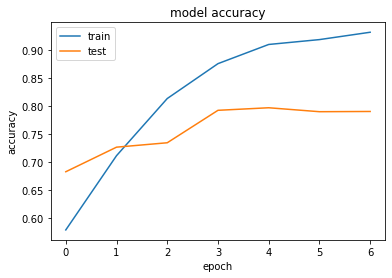

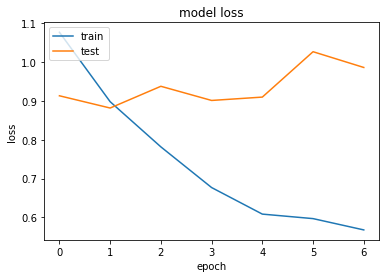

In [39]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
from sklearn import metrics

In [44]:
y_pred = model.predict(X_test)

In [48]:
np.argmax(y_pred,axis=1)

array([2, 1, 2, ..., 3, 2, 2], dtype=int64)

In [49]:
Y_test

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [45]:
print(metrics.confusion_matrix(Y_test, np.argmax(y_pred, axis=1)))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets